# Example
In this example, we'll use a single ensemble member from CESM1-LE to diagnose the forced response to external forcing near Woods Hole.  
{download}`Download notebook<./example.ipynb>`

## Imports

In [1]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import cmocean
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import copy
import pandas as pd
import time
import intake
import xesmf as xe

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## Functions

In [2]:
def trim(data, lon_range, lat_range):
    """select part of data in given longitude/latitude range"""

    ## helper function to check if 'x' is in 'x_range'
    isin_range = lambda x, x_range: (x_range[0] <= x) & (x <= x_range[1])

    ## get mask for data in given lon/lat range
    in_lon_range = isin_range(data["lon"], lon_range)
    in_lat_range = isin_range(data["lat"], lat_range)
    in_lonlat_range = in_lon_range & in_lat_range

    ## load to memory
    in_lonlat_range.load()

    if "nlon" in data.dims:

        ## Retain all points with at least one valid grid cell
        x_idx = in_lonlat_range.any("nlat")
        y_idx = in_lonlat_range.any("nlon")

        return data.isel(nlon=x_idx, nlat=y_idx)

    else:

        return data.isel(lon=in_lon_range, lat=in_lat_range)


def sort_longitude(data):
    """shuffles data so that longitude is monotonically increasing"""

    ## Transpose data so that longitude is last dimension
    ## (we'll do all the sorting along this dimension)
    data = data.transpose(..., "nlon")

    ## Get indices needed to sort longitude to be monotonic increasing
    lon_sort_idx = np.argsort(data["lon"].values, axis=-1)

    ## sort the lon/lat coordindates
    sort = lambda X, idx: np.take_along_axis(X.values, indices=idx, axis=-1)
    data["lon"].values = sort(data["lon"], idx=lon_sort_idx)
    data["lat"].values = sort(data["lat"], idx=lon_sort_idx)

    #### sort the data

    # first, check to see if data has more than two dimensions
    if data.ndim > 2:
        extra_dims = [i for i in range(data.ndim - 2)]
        lon_sort_idx = np.expand_dims(lon_sort_idx, axis=extra_dims)

    ## now, do the actual sorting
    data.values = sort(data, idx=lon_sort_idx)

    return data


def swap_longitude_range(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180]."""

    ## make copy of longitude coordinate to be modified
    lon_new = copy.deepcopy(data.lon.values)

    ## relabel values greater than 180
    exceeds_180 = lon_new > 180
    lon_new[exceeds_180] = -360 + lon_new[exceeds_180]

    ## Update the coordinate on the xarray object
    if "lon" in data.dims:
        data = data.assign_coords({"lon": lon_new})

    else:
        data["lon"].values = lon_new

    return data


def plot_setup(fig, projection, lon_range, lat_range, xticks=None, yticks=None):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    ## add tick labels
    if xticks is not None:

        ## add lon/lat labels
        gl = ax.gridlines(
            draw_labels=True,
            linestyle="-",
            alpha=0.1,
            linewidth=0.5,
            color="k",
            zorder=1.05,
        )

        ## specify which axes to label
        gl.top_labels = False
        gl.right_labels = False

        ## specify ticks
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xlocator = mticker.FixedLocator(xticks)

    return ax


def plot_box_outline(ax, lon_range, lat_range, c="k"):
    """
    Plot box outlining the specifed lon/lat range on given
    ax object.
    """

    ## get width and height
    height = lat_range[1] - lat_range[0]
    width = lon_range[1] - lon_range[0]

    ## add rectangle to plot
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lon_range[0], lat_range[0]],
            height=height,
            width=width,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor=c,
            linewidth=1,
        )
    )

    return ax


def plot_setup_atlantic(fig):
    """Plot Atlantic region"""

    ## adjust figure size
    fig.set_size_inches(7.5, 3.75)

    ## specify map projection
    proj = ccrs.Orthographic(central_longitude=-50, central_latitude=40)

    ## get ax object
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-90, -10],
        lat_range=[20, 60],
        xticks=[-80, -50, -20],
        yticks=[25, 45],
    )

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def get_empirical_pdf(x, bin_edges=None):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    if bin_edges is None:
        hist, bin_edges = np.histogram(x)

    else:
        hist, _ = np.histogram(x, bins=bin_edges)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges


def load_simulation(lens_fp, varname, member_id, simulation_type, preprocess_func=None):
    """
    Load dataset for single simulation, for single variable.
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - member_id: ID of ensemble member to load, an integer in the range [1,10]
        - simulation_type: one of {"hist", "rcp85"}
    Returns:
        - xarray dataarray with given data
    """

    #### 1. get filepath to data
    data_fp = pathlib.Path(lens_fp, varname)

    #### 2. get naming pattern for files to open
    if simulation_type == "hist":
        file_pattern = f"*20TRC*.{member_id:03d}.*.nc"

    elif simulation_type == "rcp85":
        file_pattern = f"*RCP85*.{member_id:03d}.*.nc"

    else:
        print("Not a valid simulation type")

    #### 3. open the relevant datasets, applying preprocessing function

    ## filepath to data
    fp = list(data_fp.glob(file_pattern))[0]

    ## load data
    data = xr.open_dataset(fp, chunks=None, decode_timedelta=True)

    ## apply (optional) preprocessing
    if preprocess_func is not None:
        data = preprocess_func(data)

    return data[varname].squeeze(drop=True)


def get_trend(data, dim="time", deg=1):
    """
    Get trend for an xr.dataarray along specified dimension,
    by fitting polynomial of degree 'deg'.
    """

    ## Get coefficients for best fit
    polyfit_coefs = data.polyfit(dim=dim, deg=deg)["polyfit_coefficients"]

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend


def detrend(data, dim="time", deg=1):
    """
    Remove trend of degree 'deg' from data, along dimension 'dim'.
    """

    return data - get_trend(data, dim=dim, deg=deg)


def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.lat)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["lon", "lat"])

    return avg


def load_cesm_from_cloud(
    lon_range, lat_range, varname="TREFHT", load_ssp370=False, member_id=1
):
    """Load CESM data from cloud. Args:
    - lon_range, lat_range: each is a two-element array
    - varname: variable to load ("TREFHT" is 2m-temperature)
    - load_ssp370: bool; if True, load historical AND ssp370 simulations
    - member_id: index of ensemble member to load
    """

    ## get catalog of available data
    catalog = intake.open_esm_datastore(
        "https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json"
    )

    ## subset for temperature data
    ## to look at available data, use: catalog.df
    catalog_subset = catalog.search(variable=varname, frequency="monthly")

    ## kwargs for opening data
    kwargs = dict(
        aggregate=True,
        xarray_open_kwargs=dict(engine="zarr", decode_timedelta=True),
        zarr_kwargs={"consolidated": True},
        storage_options={"anon": True},
    )

    ## open data (but don't load to memory)
    dsets = catalog_subset.to_dataset_dict(**kwargs)
    data = dsets["atm.historical.monthly.cmip6"]

    ## optionally load ssp data as well
    if load_ssp370:
        data = xr.concat([data, dsets["atm.ssp370.monthly.cmip6"]], dim="time")

    ## trim data (select ensemble members and lon/lat space)
    lonlat_idx = dict(lon=slice(*lon_range), lat=slice(*lat_range))
    data = data.sel(lonlat_idx).isel(member_id=member_id)

    ## convert kelvin to celsius
    data = data[varname] - 273.15

    ## swap longitude range
    data = swap_longitude_range(data)

    ## load to memory
    data = data.compute()

    ## regrid with land-sea mask
    ## load land-sea mask (used for interpolation)
    lsm = load_lsm_from_cloud(lon_range=lon_range, lat_range=lat_range)
    regridder = xe.Regridder(data, lsm, "bilinear", ignore_degenerate=False)
    data = regridder(data)

    return data


def load_cesm_from_server(lon_range, lat_range, lens_fp, lsm_fp, varname, member_id=10):
    """Load specified CESM1-LE ensemble member from CMIP server"""

    ## shared arguments for loading data
    load_kwargs = dict(lens_fp=lens_fp, varname=varname, member_id=member_id)

    ## Load data
    data_hist = load_simulation(simulation_type="hist", **load_kwargs).compute()
    data_rcp = load_simulation(simulation_type="rcp85", **load_kwargs).compute()

    ## concatenate in time
    data = xr.concat([data_hist, data_rcp], dim="time")

    ## rename coordinates for convenience
    data = data.rename({"TLONG": "lon", "TLAT": "lat"})

    ## subset data by longitude
    data = trim(data, lon_range=lon_range, lat_range=lat_range)

    ## swap longitude range from [0,360) to (-180, 180]
    data = swap_longitude_range(data)

    ## make sure longitude is in ascending order
    data = sort_longitude(data)

    ## interpolate onto land-sea mask with regular grid
    lsm = load_lsm_from_server(lsm_fp, lon_range=lon_range, lat_range=lat_range)
    regridder = xe.Regridder(data, lsm, "bilinear", ignore_degenerate=False)
    data = regridder(data)

    return data


def prep_lsm(lsm, lon_range, lat_range):
    """Prepare land-sea mask by renaming coords,
    downsampling to 1x1 grid, and selecting specified lon/lat range"""

    ## rename coords
    lsm = lsm.rename({"latitude": "lat", "longitude": "lon"})

    ## get coords for interpolation (downscale to 1x1 grid)
    lon = np.arange(lon_range[0], lon_range[1] + 1, 1)
    lat = np.arange(lat_range[0], lat_range[1] + 1, 1)
    new_coords = dict(lon=lon, lat=lat)

    ## interpolate to grid
    lsm = lsm.interp(new_coords)

    ## add binary mask for regridding
    lsm["mask"] = (lsm < 0.5).astype(int)

    return lsm.transpose("lat", "lon")


def load_lsm_from_cloud(lon_range, lat_range):
    """Load ERA5 land-sea-mask from Google server"""

    ## use ERA5 land-sea mask
    data = xr.open_zarr(
        "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr",
    )

    ## load lsm into memory
    lsm = data["land_sea_mask"].compute()

    return prep_lsm(lsm, lon_range=lon_range, lat_range=lat_range)


def load_lsm_from_server(lsm_fp, lon_range=[0, 360], lat_range=[-90, 90]):
    """Load ERA5 land-sea-mask from CMIP6 server"""

    ## open lsm
    lsm = xr.open_dataarray(lsm_fp).isel(time=0).drop_vars("time")

    return prep_lsm(lsm, lon_range=lon_range, lat_range=lat_range)

## Load data

### Set filepaths

````{admonition} Set filepaths to data
In previous tutorials we directed you to update ```SERVER_FP``` and hard-coded the rest of the filepath inside of the functions above. This was a mistake and made it hard for Windows users to find the data: we thought everything in the filepath *after* ```SERVER_FP``` was the same for Mac and Windows users; it's not (thanks to those who pointed this out!).  

Until we implement a better solution, we've updated the data-loading functions to take in a more complete filepath to the data. Mac users shouldn't have to change anything. Windows users: please tell us the correct path, and we'll update the code for next week!

**To-do**: Update the filepaths ```LENS_FP``` and ```LSM_FP``` in the code cell below.
````

In [5]:
## specify file paths to (i) CESM large ensemble data and (ii) land-sea mask from ERA5
##if you installed the cmip6 under a different drive, change the Z: to another letter
#for Mac users: instead of the Z: put "/Volumes/cmip6/..."
LENS_FP = pathlib.Path("Z:/data/cmip6/CMIP/NCAR/LENS")
LSM_FP = pathlib.Path(
    "Z:/data/era5/reanalysis/single-levels/monthly-means/land_sea_mask/2020_land_sea_mask.nc"
)

Check that the directory and file exist below

In [6]:
## check if LENS directory exists
print(f"LENS directory exists? {LENS_FP.is_dir()}")

## print out its contents
print(f"\nContents:")
for item in LENS_FP.glob("*"):
    print(item)

## check if land-sea mask file exists
print(f"\nLSM file exists? {LSM_FP.is_file()}")

LENS directory exists? True

Contents:
Z:\data\cmip6\CMIP\NCAR\LENS\.DS_Store
Z:\data\cmip6\CMIP\NCAR\LENS\diatChl
Z:\data\cmip6\CMIP\NCAR\LENS\PSL
Z:\data\cmip6\CMIP\NCAR\LENS\spChl
Z:\data\cmip6\CMIP\NCAR\LENS\SST

LSM file exists? True


### Do the actual loading

````{admonition} To-do (optional): specify lon/lat range
If you'd like to look at a different region, update ```LON_RANGE``` and ```LAT_RANGE``` below.

You can also update the ```varname``` parameter if you'd like to look at a variable other than ```"SST"```. Also available in the ```LENS``` directory at WHOI are: sea level pressure (```"PSL"```) and two types of chlorophyll (```"diatChl"``` and ```"spChl"```). Let us know if you'd like to look at other variables.
````

````{warning} CMIP server errors
The CMIP server seems unable to handle multiple users access the same file at once (e.g., during the actual tutorial session). If you get a mysterious error when trying to load data from the server (e.g., ```NetCDF: HDF error```), try loading the data from the cloud instead (i.e., set ```LOAD_FROM_CLOUD = True``` in the code cell below).

In order to load data from Google Cloud storage, you need to have the following packages installed:
```
- gcsfs
- s3fs
- intake-esm
```
You can install them with ```mamba``` using:
```
mamba install -n my_new_env -c conda-forge gcsfs s3fs intake-esm
```
where ```my_new_env``` is the name of your virtual environment.
````

In [7]:
## should we load from the cloud?
LOAD_FROM_CLOUD = False

## specify lon/lat range
LON_RANGE = [260, 359.9]
LAT_RANGE = [0, 70]

## arguments shared by each loading function (server and cloud)
shared_args = dict(lon_range=LON_RANGE, lat_range=LAT_RANGE, member_id=10)

## keep track of loading time
t0 = time.time()

if LOAD_FROM_CLOUD:
    data = load_cesm_from_cloud(varname="TREFHT", load_ssp370=True, **shared_args)

else:
    data = load_cesm_from_server(
        varname="SST", lens_fp=LENS_FP, lsm_fp=LSM_FP, **shared_args
    )

print(f"Elapsed time: {time.time()-t0:.1f} seconds")

Elapsed time: 35.2 seconds


### Downsample from monthly to seasonal averages

In [8]:
## get seasonal averages (omit first/last timesteps)
## (resample from monthly to quarterly starting with December, "QS-DEC")
## averages will be: "DJF", "MAM", "JJA", "SON"
data = data.resample({"time": "QS-DEC"}).mean()

### Plot a sample

````{admonition} To-do
If you're not looking at Woods Hole, you may need to adapt the plotting function below (```plot_setup_atlantic```).
````

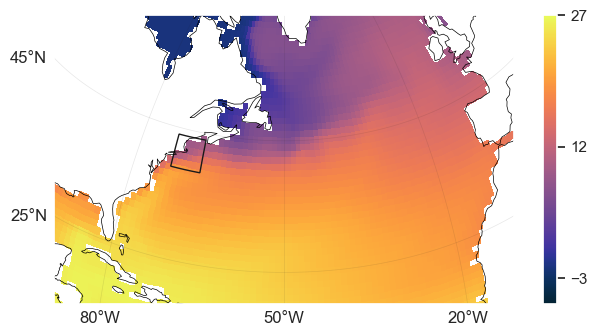

In [9]:
## blank canvas
fig = plt.figure()

## plot background
fig, ax = plot_setup_atlantic(fig)

## plot the data
plot_data = ax.pcolormesh(
    data.lon,
    data.lat,
    data.isel(time=0),
    cmap="cmo.thermal",
    vmax=27,
    vmin=-6,
    # levels=np.arange(-6, 30, 3),
    transform=ccrs.PlateCarree(),
    # extend="both",
)

## make a colorbar
cb = fig.colorbar(plot_data, ticks=[-3, 12, 27])

## plot outline of region
ax = plot_box_outline(ax, lon_range=[287.5, 293.5], lat_range=[39, 44])

plt.show()

## Woods Hole SST index over time

### Compute index

````{admonition} To-do
If you'd like to look at a different index, modify the function below.
````

In [12]:
def compute_T_wh(x):
    """Compute Woods Hole temperature index"""

    ## get subset of data inside the box
    lonlat_idx = dict(lon=slice(287.5, 293.5), lat=slice(39, 44))
    data_subset = x.sel(lonlat_idx)

    return spatial_avg(data_subset)

Do the computational, and get seasonal averages

In [13]:
## do the computation here
idx = compute_T_wh(data)

## compute SON average
is_son = idx.time.dt.month == 9
idx_son = idx.isel(time=is_son)
idx_son["time"] = idx_son.time.dt.year

### SON trend and anomalies

In [14]:
## compute trends (linear and quadratic)
idx_son_trend1 = get_trend(idx_son, dim="time", deg=1)
idx_son_trend2 = get_trend(idx_son, dim="time", deg=2)

## estimate anomalies (using quadratic)
idx_son_anom = idx_son - idx_son_trend2

#### Plotting function

In [15]:
def setup_trend_plot():
    """create fig and axs for plotting trends"""

    ## blank canvas
    fig, axs = plt.subplots(1, 2, figsize=(7, 2.75), layout="constrained")

    #### label plots
    for ax in axs:
        ax.set_xticks([1920, 2006, 2080])
        ax.set_xlabel("Year")
        ax.set_ylabel(r"$^{\circ}$C")

    axs[0].set_yticks([22, 24.5, 27])
    axs[1].set_yticks([-1, 0, 1])
    axs[0].set_title("Total")
    axs[1].set_title("Anomaly")
    axs[1].axhline(0, c="k", zorder=0.5, lw=0.5)
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")

    for ax in axs:
        ## plot boundary between HIST and RCP
        ax.axvline(2006, ls="--", lw=0.5, c="k")

    return fig, axs

#### Make the plot

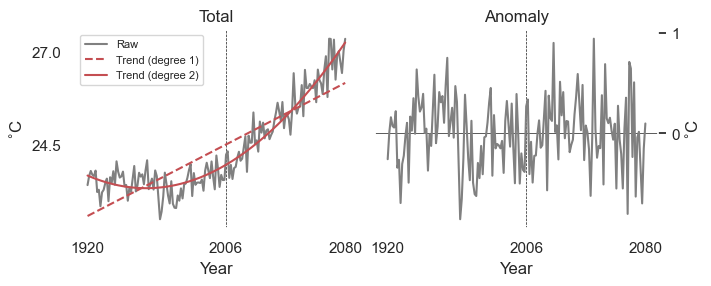

In [16]:
fig, axs = setup_trend_plot()

## plot raw index
axs[0].plot(idx_son.time, idx_son, c="gray", label="Raw")

# get list for (i) trends and (ii) corresponding linestyles
trends = [idx_son_trend1, idx_son_trend2]
linestyles = ["--", "-"]

# plot each trend with corresponding linestyle
for i, (trend, ls) in enumerate(zip(trends, linestyles), start=1):

    kwargs = dict(c="r", ls=ls, label=f"Trend (degree {i})")
    axs[0].plot(trend.time, trend, **kwargs)

## on RHS sub-panel, plot anomalies
axs[1].plot(idx_son_anom.time, idx_son_anom, c="gray")

## add legend
axs[0].legend(prop=dict(size=8))

plt.show()

## Spatial pattern of warming

#### Function to compute climatology for given period and month

In [17]:
def get_clim(data, yr_range, QS_month=9):
    """function to get SON climatology for specified range"""

    ## find samples in given quarter
    in_quarter = data.time.dt.month == QS_month

    ## subset for samples in quarter
    data_subset = data.sel(time=in_quarter)

    ## subset for samples in year range
    data_subset = data_subset.sel(time=slice(*yr_range))

    ## average in time
    return data_subset.mean("time")

#### Do computation

In [18]:
## compare SON averages in two 30-yr periods
yr_range0 = ["1980", "2010"]
yr_range1 = ["2050", "2080"]

## get SON climatology for each period
clim0 = get_clim(data, yr_range=yr_range0, QS_month=9)
clim1 = get_clim(data, yr_range=yr_range1, QS_month=9)

## get difference
delta_clim = clim1 - clim0

#### Plot difference

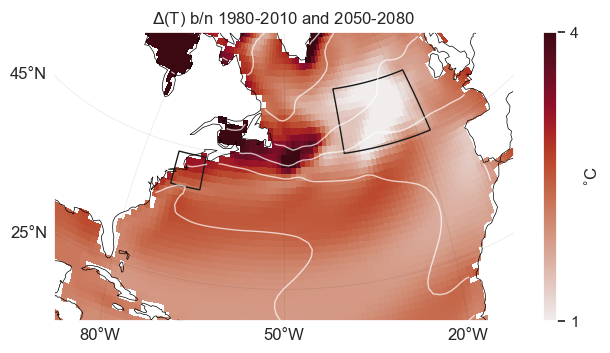

In [19]:
## set colorbar levels
if LOAD_FROM_CLOUD:
    plot_kwargs = dict(vmin=-3, vmax=3, cmap="cmo.balance")
    ticks = [-3, 0, 3]

else:
    plot_kwargs = dict(vmin=1, vmax=4, cmap="cmo.amp")
    ticks = [1, 4]

## blank canvas
fig = plt.figure()

## plot background
fig, ax = plot_setup_atlantic(fig)

## plot the difference
plot_data = ax.pcolormesh(
    data.lon,
    data.lat,
    delta_clim,
    transform=ccrs.PlateCarree(),
    **plot_kwargs,
)

## plot the background state
ax.contour(
    data.lon,
    data.lat,
    clim0,
    colors="w",
    levels=np.arange(-2, 34, 4),
    transform=ccrs.PlateCarree(),
    extend="both",
    linewidths=1,
    alpha=0.7,
)

## make a colorbar
cb = fig.colorbar(plot_data, ticks=ticks, label=r"$^{\circ}$C")

## plot outline of Woods Hole region
ax = plot_box_outline(ax, lon_range=[287.5, 293.5], lat_range=[39, 44])

## plot outline of warming hole region
ax = plot_box_outline(ax, lon_range=[323, 343], lat_range=[45, 55])

## label
ax.set_title(r"$\Delta$(T) b/n 1980-2010 and 2050-2080")

plt.show()

## Assess robustness in forced changes

### Compute warming hole index (as comparison point)

In [20]:
def compute_warming_hole_idx(x):
    """Compute Woods Hole temperature index"""

    ## get subset of data inside the box
    lonlat_idx = dict(lon=slice(323, 343), lat=slice(45, 55))
    data_subset = x.sel(lonlat_idx)

    ## compute spatial average
    return spatial_avg(data_subset)


idx_warminghole = compute_warming_hole_idx(data)

### Function to compute PDF for specified (i) year range and (ii) season

In [23]:
def get_pdf_helper(data, yr_range, bin_edges, QS_month=9):
    """function to get SON climatology for specified range"""

    if QS_month is not None:

        ## find samples in given quarter
        in_quarter = data.time.dt.month == QS_month

        ## subset for samples in quarter
        data_subset = data.sel(time=in_quarter)

    else:
        data_subset = data

    ## subset for samples in year range
    data_subset = data_subset.sel(time=slice(*yr_range))

    ## compute PDF
    pdf, _ = get_empirical_pdf(data_subset, bin_edges)

    ## average in time
    return pdf

### Compute PDFs

In [24]:
## specify edges for PDFs
if LOAD_FROM_CLOUD:
    edges_woodshole = np.arange(17, 23.3, 0.4)
    edges_warminghole = np.arange(10, 16.2, 0.4)

else:
    edges_woodshole = np.arange(21.6, 28, 0.4)
    edges_warminghole = np.arange(13, 19.2, 0.4)

## for Woods Hole idx
pdf_woodshole0 = get_pdf_helper(idx, yr_range0, bin_edges=edges_woodshole)
pdf_woodshole1 = get_pdf_helper(idx, yr_range1, bin_edges=edges_woodshole)

## for warming hole index
pdf_warminghole0 = get_pdf_helper(
    idx_warminghole, yr_range0, bin_edges=edges_warminghole
)
pdf_warminghole1 = get_pdf_helper(
    idx_warminghole, yr_range1, bin_edges=edges_warminghole
)

### Plot PDFs

Function to setup plot

In [25]:
def plot_setup_pdfs():
    """Plot background for PDFs"""

    fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), layout="constrained")

    ## format/label axes
    axs[1].set_yticks([])
    axs[0].set_title("Woods Hole")
    axs[1].set_title("'Warming hole'")
    axs[0].set_ylabel("Prob. density")
    axs[0].set_yticks([0, 0.5, 1])

    for ax in axs:
        ax.set_xlabel(r"$^{\circ}$C")

    return fig, axs

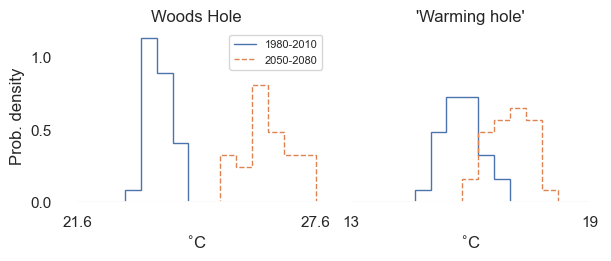

In [26]:
## set up plot
fig, axs = plot_setup_pdfs()

## plot woods hole index
axs[0].stairs(pdf_woodshole0, edges_woodshole, label="1980-2010")
axs[0].stairs(pdf_woodshole1, edges_woodshole, ls="--", label="2050-2080")

## plot warming hole index
axs[1].stairs(pdf_warminghole0, edges_warminghole)
axs[1].stairs(pdf_warminghole1, edges_warminghole, ls="--")

## format/label axes
axs[1].set_ylim(axs[0].get_ylim())
axs[0].legend(prop=dict(size=8))
axs[0].set_xticks([edges_woodshole.min(), edges_woodshole.max()])
axs[1].set_xticks([edges_warminghole.min(), edges_warminghole.max()])

plt.show()

## Look at changes in internal variability

### Detrend both indices

In [27]:
def detrend_bymonth(x):
    """detrend given index with 2nd degree polynomial"""

    ## function to quadratic detrend
    detrend_quadratic = lambda x: detrend(x, dim="time", deg=2)

    ## apply quadratic detrending to each month separately
    return x.groupby("time.month").map(detrend_quadratic)


## apply detrending
idx_anom = detrend_bymonth(idx)
idx_warminghole_anom = detrend_bymonth(idx_warminghole)

### Compute PDFs

In [28]:
## shared arguments for PDFs
edges = 0.125 + np.arange(-1.5, 1.5, 0.25)
kwargs = dict(bin_edges=edges, QS_month=None)

# ## for Woods Hole idx
pdf_woodshole0 = get_pdf_helper(idx_anom, yr_range0, **kwargs)
pdf_woodshole1 = get_pdf_helper(idx_anom, yr_range1, **kwargs)

## for warming hole index
pdf_warminghole0 = get_pdf_helper(idx_warminghole_anom, yr_range0, **kwargs)
pdf_warminghole1 = get_pdf_helper(idx_warminghole_anom, yr_range1, **kwargs)

### Plot PDFs

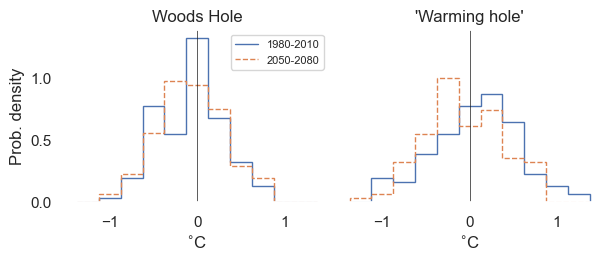

In [29]:
## set up plot
fig, axs = plot_setup_pdfs()

## plot woods hole index
axs[0].stairs(pdf_woodshole0, edges, label="1980-2010")
axs[0].stairs(pdf_woodshole1, edges, ls="--", label="2050-2080")

## plot warming hole index
axs[1].stairs(pdf_warminghole0, edges)
axs[1].stairs(pdf_warminghole1, edges, ls="--")

## format/label axes
axs[1].set_ylim(axs[0].get_ylim())
axs[0].legend(prop=dict(size=8))

for ax in axs:
    ax.axvline(0, c="k", lw=0.5)

plt.show()